# **Acknowledgment**

This notebook mainly use codes from https://github.com/huggingface/transformers/blob/master/examples/tensorflow/text-classification/run_text_classification.py and modified accordingly.
```
#!/usr/bin/env python
# coding=utf-8
# Copyright 2021 The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" Fine-tuning the library models for sequence classification."""
# You can also adapt this script on your own text classification task. Pointers for this are left as comments.
```


**Other References**
* https://towardsdatascience.com/tensorflow-and-transformers-df6fceaf57cc
* https://towardsdatascience.com/working-with-hugging-face-transformers-and-tf-2-0-89bf35e3555a


**Pre-trained Language Model: ```indobenchmark/indobert-lite-base-p1``` from:**
```
@inproceedings{wilie2020indonlu,
  title={IndoNLU: Benchmark and Resources for Evaluating Indonesian Natural Language Understanding},
  author={Bryan Wilie and Karissa Vincentio and Genta Indra Winata and Samuel Cahyawijaya and X. Li and Zhi Yuan Lim and S. Soleman and R. Mahendra and Pascale Fung and Syafri Bahar and A. Purwarianti},
  booktitle={Proceedings of the 1st Conference of the Asia-Pacific Chapter of the Association for Computational Linguistics and the 10th International Joint Conference on Natural Language Processing},
  year={2020}
}
```

In [2]:
from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = 'drive/My Drive/Bangkit Capstone PT CJNN/ML/'
SAMSUM_ID_PATH = PROJECT_ROOT + 'dataset/emotion_detection/'

Mounted at /content/drive
time: 18.1 s (started: 2021-05-22 07:57:42 +00:00)


In [1]:
!pip install --upgrade transformers
!pip install simpletransformers
!pip install ipython-autotime
%load_ext autotime

import os, sys
import logging
import json
import re
import time
import pandas as pd
import numpy as np
import tensorflow as tf

from functools import partial
from datetime import timedelta
from datasets import load_dataset
from matplotlib import pyplot as plt
from transformers import AlbertConfig, BertTokenizer, TFAlbertForSequenceClassification, TFTrainingArguments, set_seed
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, classification_report

Requirement already up-to-date: transformers in /usr/local/lib/python3.7/dist-packages (4.6.1)
time: 2.55 s (started: 2021-05-22 07:57:39 +00:00)


In [ ]:
# cd drive/My Drive/Bangkit Capstone PT CJNN/ML/dataset/emotion_detection/

time: 1.64 ms (started: 2021-05-19 12:54:16 +00:00)


In [ ]:
!ls

drive  sample_data
time: 132 ms (started: 2021-05-19 12:54:16 +00:00)


In [ ]:
from transformers.file_utils import CONFIG_NAME, TF2_WEIGHTS_NAME
print(CONFIG_NAME)
print(TF2_WEIGHTS_NAME)

config.json
tf_model.h5
time: 3.7 ms (started: 2021-05-19 12:54:17 +00:00)


### Load Dataset

In [ ]:
# df = pd.read_csv('train_emotion.csv')
# happyjoy = {"label": {"joy": "happy"}}
# df = df.replace(happyjoy)
# df.to_csv('train_emotion_final.csv',  index=False, header=True)

time: 1.87 ms (started: 2021-05-19 12:54:17 +00:00)


## Dataset

In [ ]:
df = pd.read_csv('drive/My Drive/Bangkit Capstone PT CJNN/ML/dataset/emotion_detection/train_emotion_fix.csv')

time: 39 ms (started: 2021-05-19 12:54:17 +00:00)


In [ ]:
# cari yg nyebabin error, yaitu yg ada \r
df.loc[df['sentence1'].str.find('\r') != -1]

,label,sentence1


time: 26.8 ms (started: 2021-05-19 12:54:17 +00:00)


In [ ]:
df['label'].value_counts()

anger      1958
fear       1796
sadness    1783
joy        1740
Name: label, dtype: int64

time: 11.8 ms (started: 2021-05-19 12:54:17 +00:00)


In [ ]:
measurer = np.vectorize(len)
max_seq_len_train = measurer(df['sentence1'].values.astype(str)).max(axis=0)

print('Maximum sequence length in training data'.ljust(42), ':', max_seq_len_train)

Maximum sequence length in training data   : 500
time: 23.4 ms (started: 2021-05-19 12:54:17 +00:00)


In [10]:
PRETRAINED_MODEL = 'indobenchmark/indobert-lite-base-p1'
LABEL2ID =  {'anger':0, 'fear': 1, 'sadness':2, 'joy':3}

time: 1.61 ms (started: 2021-05-22 08:13:16 +00:00)


## Helper Function

In [ ]:
def preprocess_function(data, tokenizer, non_label_column_names):
    # Tokenize the texts
    args = (data['sentence1'],) if 'sentence2' not in non_label_column_names else (data['sentence1'], data['sentence2'])
    result = tokenizer(*args, max_length=max_seq_len_train, truncation=True, padding=True,
                                add_special_tokens=True, return_attention_mask=True, return_token_type_ids=True)

    # Map labels to IDs
    if LABEL2ID is not None and 'label' in data:
        result['label'] = [LABEL2ID[l] for l in data['label']]
    return result

time: 7.58 ms (started: 2021-05-19 12:54:17 +00:00)


In [ ]:
class SavePretrainedCallback(tf.keras.callbacks.Callback):
    # Hugging Face models have a save_pretrained() method that saves both the weights and the necessary
    # metadata to allow them to be loaded as a pretrained model in future. This is a simple Keras callback
    # that saves the model with this method after each epoch.
    def __init__(self, output_dir, **kwargs):
        super().__init__()
        self.output_dir = output_dir

    def on_epoch_end(self, epoch, logs=None):
        self.model.save_pretrained(self.output_dir)

time: 7 ms (started: 2021-05-19 12:54:17 +00:00)


In [ ]:
def convert_dataset_for_tensorflow(
    dataset, non_label_column_names, batch_size, dataset_mode='variable_batch', shuffle=True, drop_remainder=True
):
    '''
      Converts a Hugging Face dataset to a Tensorflow Dataset. The dataset_mode controls whether we pad all batches
      to the maximum sequence length, or whether we only pad to the maximum length within that batch. The former
      is most useful when training on TPU, as a new graph compilation is required for each sequence length.
    '''

    def densify_ragged_batch(features, label=None):
        features = {
            feature: ragged_tensor.to_tensor(shape=batch_shape[feature]) for feature, ragged_tensor in features.items()
        }
        if label is None:
            return features
        else:
            return features, label

    feature_keys = list(set(dataset.features.keys()) - set(non_label_column_names + ['label'])) # only take the tokenized embeddings
    if dataset_mode == 'variable_batch':
        batch_shape = {key: None for key in feature_keys}
        data = {key: tf.ragged.constant(dataset[key]) for key in feature_keys}
    elif dataset_mode == 'constant_batch':
        data = {key: tf.ragged.constant(dataset[key]) for key in feature_keys}
        batch_shape = {
            key: tf.concat(([batch_size], ragged_tensor.bounding_shape()[1:]), axis=0)
            for key, ragged_tensor in data.items()
        }
    else:
        raise ValueError('Unknown dataset mode!')

    if 'label' in dataset.features:
        labels = tf.convert_to_tensor(np.array(dataset['label']))
        tf_dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    else:
        tf_dataset = tf.data.Dataset.from_tensor_slices(data)
    
    if shuffle:
        tf_dataset = tf_dataset.shuffle(buffer_size=len(dataset))
    
    tf_dataset = tf_dataset.batch(batch_size=batch_size, drop_remainder=drop_remainder).map(densify_ragged_batch)
    return tf_dataset

time: 180 ms (started: 2021-05-19 12:54:17 +00:00)


In [ ]:
def classification_metrics(list_true, list_preds):
    metrics = {}
    metrics['ACC'] = accuracy_score(list_true, list_preds)
    metrics['F1'] = f1_score(list_true, list_preds, average='weighted')
    metrics['REC'] = recall_score(list_true, list_preds, average='weighted')
    metrics['PRE'] = precision_score(list_true, list_preds, average='weighted')
    return metrics

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append(f'\033[1m{key}:\033[0m{value:.4f}')
    return ' '.join(string_list)

time: 6.5 ms (started: 2021-05-19 12:54:17 +00:00)


In [ ]:
def plot_history(history):
    epochs = range(1, len(history['val_loss']) + 1)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    axes[0].set_title('Training and Validation Loss')
    axes[0].plot(epochs, history['val_loss'], label='val loss')
    axes[0].plot(epochs, history['loss'], label='train loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend(loc='best')

    axes[1].set_title('Training and Validation Accuracy')
    axes[1].plot(epochs, history['val_accuracy'], label='val accuracy')
    axes[1].plot(epochs, history['accuracy'], label='train accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(loc='best')

time: 11.9 ms (started: 2021-05-19 12:54:17 +00:00)


In [ ]:
def main(datasets, training_args, config, non_label_column_names, PRETRAINED_MODEL=PRETRAINED_MODEL):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # Reduce the amount of console output from TF
    logger = logging.getLogger(__name__)


    with training_args.strategy.scope():
        set_seed(training_args.seed)

        model = TFAlbertForSequenceClassification.from_pretrained(PRETRAINED_MODEL, config=config)

        optimizer = tf.keras.optimizers.Adam(
                learning_rate=training_args.learning_rate,
                clipnorm=training_args.max_grad_norm,
            )
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        acc = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
        model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

        # Convert data to TF format
        # Convert data to a tf.keras.utils.Sequence object for training if we're not using a TPU
        # For TPU, convert to a tf.data.Dataset
        tf_data = dict()
        for key in ('train', 'validation', 'test'):
            if key == 'train':
                shuffle = True
                batch_size = training_args.per_device_train_batch_size
                drop_remainder = True  # Saves us worrying about scaling gradients for the last batch
            else:
                shuffle = False
                batch_size = training_args.per_device_eval_batch_size
                drop_remainder = False

            dataset = datasets[key]
            if isinstance(training_args.strategy, tf.distribute.TPUStrategy):
                logger.info("Padding all batches to max length because argument was set or we're on TPU.")
                dataset_mode = 'constant_batch'
            else:
                dataset_mode = 'variable_batch'

            data = convert_dataset_for_tensorflow(
                dataset,
                non_label_column_names,
                batch_size=batch_size,
                dataset_mode=dataset_mode,
                drop_remainder=drop_remainder,
                shuffle=shuffle,
            )
            tf_data[key] = data

        # Training and validation
        training_start_time = time.time()
        history = None
        if tf_data['train'] is not None and training_args.do_train:
            callbacks = [SavePretrainedCallback(output_dir=training_args.output_dir),
                         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
            history = model.fit(
                      tf_data['train'],
                      validation_data=tf_data['validation'],
                      epochs=int(training_args.num_train_epochs),
                      callbacks=callbacks,
            )
        elif tf_data['validation'] is not None and training_args.do_eval:
            # If there's a validation dataset but no training set, just evaluate the metrics
            logger.info('Computing metrics on validation data...')
            loss, acc = model.evaluate(tf_data['validation'])
            logger.info(f'Loss: {loss:.5f}, Accuracy: {acc * 100:.4f}%')

        finished = time.time() - training_start_time
        finished = str(timedelta(seconds=finished))

        # Prediction
        if tf_data['test'] is not None and training_args.do_predict:
            logger.info('Doing predictions on test dataset...')
            predictions = model.predict(tf_data['test'])['logits']
            predicted_class_idx = np.argmax(predictions, axis=1)
            predicted_class_name = [config.id2label[idx] for idx in predicted_class_idx]
            output_test_file = os.path.join(training_args.output_dir, 'test_preds.csv')
            pd.DataFrame(predicted_class_name, columns=['prediction']).to_csv(output_test_file)
            logger.info(f'Wrote predictions to {output_test_file}!')

    # region Prediction losses
    # This section is outside the scope() because it's very quick to compute, but behaves badly inside it
    if 'test' in datasets and 'label' in datasets['test'].features and training_args.do_predict:
        print('\n')
        print(' \033[1mMODEL PERFORMANCE ON TEST SET\033[0m '.center(100, '='))
        labels_idx = datasets['test']['label']
        labels_name = [config.id2label[idx] for idx in labels_idx]
        loss = float(loss(labels_idx, predictions).numpy())
        print(f'\033[1mLoss\033[0m:{loss:.4f}', metrics_to_string(classification_metrics(labels_idx, predicted_class_idx)))
        print('\n\033[1mClassification Report:\033[0m')
        print(classification_report(labels_name, predicted_class_name))    
    # endregion

    if tf_data['train'] is not None and training_args.do_train:
        print('\n')
        print(' \033[1mTRAINING AND VALIDATION PERFORMANCE\033[0m '.center(100, '='))
        print('\033[1mTotal Training and Validation Time:\033[0m', finished)
        print('\n\033[1mPerformance Over Epochs:\033[0m')
        plot_history(history.history)

    return history

time: 121 ms (started: 2021-05-19 12:54:17 +00:00)


### Load

In [11]:
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL, do_lower_case=True)
tokenizer

Downloading:   0%|          | 0.00/225k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='indobenchmark/indobert-lite-base-p1', vocab_size=29999, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

time: 2.04 s (started: 2021-05-22 08:13:40 +00:00)


In [ ]:
# Configuration
config_ori = AlbertConfig.from_pretrained(PRETRAINED_MODEL,
                                    label2id=LABEL2ID,
                                    id2label={id: label for label, id in LABEL2ID.items()},
                                    _num_labels = len(LABEL2ID),
                                    output_attentions=False,
                                    output_hidden_states=False,
                                    use_cache=False
          )
config_ori

AlbertConfig {
  "_num_labels": 4,
  "architectures": [
    "AlbertModel"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "fear",
    "2": "sadness",
    "3": "joy"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "fear": 1,
    "joy": 3,
    "sadness": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0",
  "type_vocab_size": 2,
  "vocab_size": 30000
}

time: 570 ms (started: 2021-05-19 12:54:20 +00:00)


In [ ]:
# Configuration
config_ft = AlbertConfig.from_pretrained(PRETRAINED_MODEL,
                                    label2id=LABEL2ID,
                                    id2label={id: label for label, id in LABEL2ID.items()},
                                    _num_labels = len(LABEL2ID),
                                    attention_probs_dropout_prob = 0.2,
                                    num_hidden_layers = 8,
                                    num_attention_heads= 12,
                                    output_attentions=False,
                                    output_hidden_states=False,
                                    use_cache=False
          )
config_ft

AlbertConfig {
  "_num_labels": 4,
  "architectures": [
    "AlbertModel"
  ],
  "attention_probs_dropout_prob": 0.2,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "fear",
    "2": "sadness",
    "3": "joy"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "fear": 1,
    "joy": 3,
    "sadness": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 8,
  "num_memory_blocks": 0,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0",
  "type_vocab_size": 2,
  "vocab_size": 30000
}

time: 572 ms (started: 2021-05-19 12:54:21 +00:00)


### Load Dataset

In [ ]:
!ls

drive  sample_data
time: 128 ms (started: 2021-05-19 12:54:22 +00:00)


In [ ]:
data_files = {'train': 'drive/My Drive/Bangkit Capstone PT CJNN/ML/dataset/emotion_detection/train_emotion_fix.csv', 
              'validation': 'drive/My Drive/Bangkit Capstone PT CJNN/ML/dataset/emotion_detection/dev_emotion_fix.csv',
              'test': 'drive/My Drive/Bangkit Capstone PT CJNN/ML/dataset/emotion_detection/test_emotion_fix.csv'}

datasets = load_dataset('csv', data_files=data_files)
datasets

Using custom data configuration default-5efba6a713117dd0


0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-5efba6a713117dd0/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['label', 'sentence1'],
        num_rows: 7277
    })
    validation: Dataset({
        features: ['label', 'sentence1'],
        num_rows: 347
    })
    test: Dataset({
        features: ['label', 'sentence1'],
        num_rows: 3047
    })
})

time: 1.16 s (started: 2021-05-19 12:54:22 +00:00)


In [ ]:
column_names = {col for cols in datasets.column_names.values() for col in cols}
non_label_column_names = [name for name in column_names if name != 'label']

time: 1.95 ms (started: 2021-05-19 12:54:23 +00:00)


In [ ]:
partial_preprocess_func = partial(preprocess_function, tokenizer=tokenizer, non_label_column_names=non_label_column_names)
datasets = datasets.map(partial_preprocess_func, batched=True)
datasets

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'sentence1', 'token_type_ids'],
        num_rows: 7277
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'sentence1', 'token_type_ids'],
        num_rows: 347
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'sentence1', 'token_type_ids'],
        num_rows: 3047
    })
})

time: 9.23 s (started: 2021-05-19 12:54:23 +00:00)


### Base

In [ ]:
training_args_ori = TFTrainingArguments(
    output_dir= 'drive/My Drive/Bangkit Capstone PT CJNN/ML/results/em/albert/ori/',                        # output directory
    do_train=False,
    do_predict=True,
    do_eval=False,
    num_train_epochs=25,                                                # total number of training epochs
    per_device_train_batch_size=16,                                     # batch size per device during training
    per_device_eval_batch_size=16,                                      # batch size for evaluation
    learning_rate=4e-5,
    max_grad_norm=10,
    seed=42
)

time: 54.6 ms (started: 2021-05-19 12:54:32 +00:00)


In [ ]:
main(datasets, training_args_ori, config_ori, non_label_column_names, PRETRAINED_MODEL)

Some layers from the model checkpoint at indobenchmark/indobert-lite-base-p1 were not used when initializing TFAlbertForSequenceClassification: ['sop_classifier']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFAlbertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Transfer Learning

In [ ]:
training_args_tl = TFTrainingArguments(
    output_dir= 'drive/My Drive/Bangkit Capstone PT CJNN/ML/results/em/albert/transfer-learning/',           # output directory
    do_train=True,
    do_predict=True,
    do_eval=True,
    num_train_epochs=25,                                                # total number of training epochs
    per_device_train_batch_size=16,                                     # batch size per device during training
    per_device_eval_batch_size=16,                                      # batch size for evaluation
    learning_rate=1e-5,
    max_grad_norm=10,
    seed=42
)

time: 7.93 ms (started: 2021-05-19 12:55:50 +00:00)


Some layers from the model checkpoint at indobenchmark/indobert-lite-base-p1 were not used when initializing TFAlbertForSequenceClassification: ['sop_classifier']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFAlbertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/25
454/454 [==============================] - 371s 779ms/step - loss: 1.2937 - accuracy: 0.3750 - val_loss: 1.0981 - val_accuracy: 0.5476
Epoch 2/25
454/454 [==============================] - 349s 768ms/step - loss: 0.8086 - accuracy: 0.6962 - val_loss: 0.9636 - val_accuracy: 0.5965
Epoch 3/25
454/454 [==============================] - 350s 770ms/step - loss: 0.5623 - accuracy: 0.8042 - val_loss: 0.9134 - val_accuracy: 0.6542
Epoch 4/25
454/454 [==============================] - 348s 767ms/step - loss: 0.3550 - accuracy: 0.8879 - val_loss: 0.9328 - val_accuracy: 0.6599
Epoch 5/25
454/454 [==============================] - 349s 768ms/step - loss: 0.1967 - accuracy: 0.9454 - val_loss: 1.1083 - val_accuracy: 0.6513
Epoch 6/25
454/454 [==============================] - 348s 767ms/step - loss: 0.1064 - accuracy: 0.9735 - val_loss: 1.2135 - val_accuracy: 0.6427


============================== MODEL PERFORMANCE ON TEST SET ===============================
Loss:1.1724 ACC:0.6659 F1:0.6

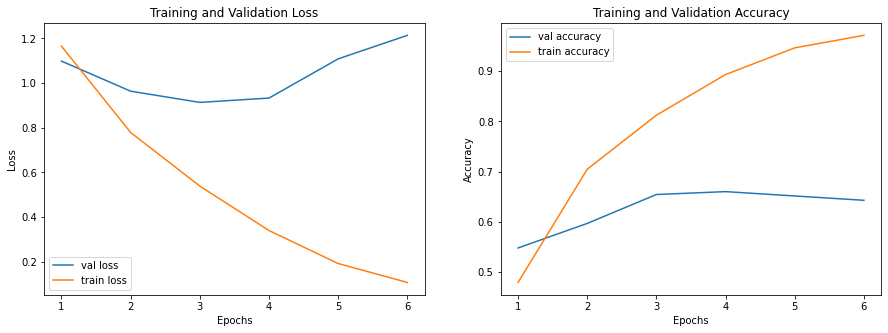

time: 36min (started: 2021-05-19 12:55:50 +00:00)


In [ ]:
history_tl = main(datasets, training_args_tl, config_ori, non_label_column_names, PRETRAINED_MODEL)

In [ ]:
history_tl.model.summary()

Model: "tf_albert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
albert (TFAlbertMainLayer)   multiple                  11683584  
_________________________________________________________________
dropout_9 (Dropout)          multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3076      
Total params: 11,686,660
Trainable params: 11,686,660
Non-trainable params: 0
_________________________________________________________________
time: 10.3 ms (started: 2021-05-19 13:31:50 +00:00)


### Tuning

In [ ]:
training_args_ft = TFTrainingArguments(
    output_dir= 'drive/My Drive/Bangkit Capstone PT CJNN/ML/results/em/albert/fine-tuning/',         # output directory
    do_train=True,
    do_predict=True,
    do_eval=True,
    num_train_epochs=25,                                                # total number of training epochs
    per_device_train_batch_size=16,                                     # batch size per device during training
    per_device_eval_batch_size=16,                                      # batch size for evaluation
    learning_rate=4e-5,
    max_grad_norm=10,
    seed=42
)

time: 15.5 ms (started: 2021-05-19 13:31:50 +00:00)


Some layers from the model checkpoint at indobenchmark/indobert-lite-base-p1 were not used when initializing TFAlbertForSequenceClassification: ['sop_classifier']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFAlbertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/25
454/454 [==============================] - 250s 525ms/step - loss: 1.1922 - accuracy: 0.4434 - val_loss: 0.8876 - val_accuracy: 0.6542
Epoch 2/25
454/454 [==============================] - 236s 521ms/step - loss: 0.6746 - accuracy: 0.7556 - val_loss: 0.8710 - val_accuracy: 0.6772
Epoch 3/25
454/454 [==============================] - 236s 521ms/step - loss: 0.4710 - accuracy: 0.8356 - val_loss: 0.9164 - val_accuracy: 0.6859
Epoch 4/25
454/454 [==============================] - 236s 519ms/step - loss: 0.2863 - accuracy: 0.9001 - val_loss: 0.9529 - val_accuracy: 0.7032
Epoch 5/25
454/454 [==============================] - 236s 519ms/step - loss: 0.1854 - accuracy: 0.9377 - val_loss: 1.1192 - val_accuracy: 0.7061


============================== MODEL PERFORMANCE ON TEST SET ===============================
Loss:0.9474 ACC:0.7342 F1:0.7360 REC:0.7342 PRE:0.7476

Classification Report:
              precision    recall  f1-score   support

       anger       0.74      0.74      0.

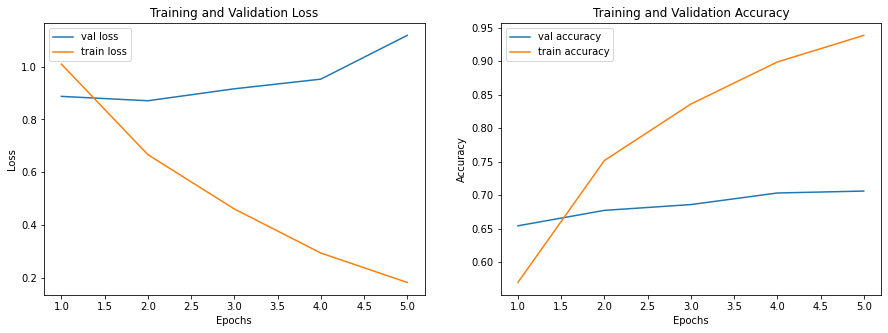

time: 20min 29s (started: 2021-05-19 13:31:50 +00:00)


In [ ]:
history_ft = main(datasets, training_args_ft, config_ft, non_label_column_names, PRETRAINED_MODEL)

## Push to HuggingFace

In [4]:
!transformers-cli login

2021-05-22 08:00:26.639019: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        
Username: celine
Password: 
Login successful
Your token: dHWKZHtSTVmTuuoYovdmVkJRFrVMAdhMJNaMXBcaYUzFZWFfJgUHLTgetFNcEJmYZLxNpbPeRhyrcJSWquqvLZBjQQVFtdupYnZHTagKhYfrrkVUlKjmEJwCYhKwCYNB 

Your token has been saved to /root/.huggingface/token
time: 13.7

In [5]:
# https://github.com/git-lfs/git-lfs/issues/3605
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 74 not upgraded.
Need to get 6,229 kB of archives.
After this operation, 14.5 MB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu bionic/main amd64 git-lfs amd64 2.13.3 [6,229 kB]
Fetched 6,229 kB in 0s (18.0 MB/s)
debconf: unable to init

In [6]:
!git config --global user.email "chrysant.celine@ui.ac.id"
!git config --global user.name "celine"

time: 237 ms (started: 2021-05-22 08:03:10 +00:00)


In [7]:
ft_model = TFAlbertForSequenceClassification.from_pretrained(PROJECT_ROOT + 'results/em/albert/fine-tuning')

Some layers from the model checkpoint at drive/My Drive/Bangkit Capstone PT CJNN/ML/results/em/albert/fine-tuning were not used when initializing TFAlbertForSequenceClassification: ['dropout_14']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertForSequenceClassification were initialized from the model checkpoint at drive/My Drive/Bangkit Capstone PT CJNN/ML/results/em/albert/fine-tuning.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertForSequenceClassificati

time: 11.7 s (started: 2021-05-22 08:10:29 +00:00)


In [12]:
save_directory = PROJECT_ROOT + 'results/em/albert/fine-tuning'
ft_model.save_pretrained(save_directory, push_to_hub=True, repo_name='emotion-detection_indobenchmark-indobert-lite-base-p1')
tokenizer.push_to_hub('emotion-detection_indobenchmark-indobert-lite-base-p1')

time: 16.6 s (started: 2021-05-22 08:13:50 +00:00)


In [13]:
PRETRAINED_MODEL_ED = 'celine/emotion-detection_indobenchmark-indobert-lite-base-p1'
ed_tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_ED)
ed_model = TFAlbertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_ED)
ed_config = AlbertConfig.from_pretrained(PRETRAINED_MODEL_ED)

Downloading:   0%|          | 0.00/225k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/515 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some layers from the model checkpoint at celine/emotion-detection_indobenchmark-indobert-lite-base-p1 were not used when initializing TFAlbertForSequenceClassification: ['dropout_4']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertForSequenceClassification were initialized from the model checkpoint at celine/emotion-detection_indobenchmark-indobert-lite-base-p1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertForSequenceClassification for predictions withou

time: 4.3 s (started: 2021-05-22 08:14:11 +00:00)


In [14]:
ed_config

AlbertConfig {
  "_name_or_path": "drive/My Drive/Bangkit Capstone PT CJNN/ML/results/em/albert/fine-tuning",
  "_num_labels": 4,
  "architectures": [
    "AlbertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.2,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "fear",
    "2": "sadness",
    "3": "joy"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "fear": 1,
    "joy": 3,
    "sadness": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 8,
  "num_memory_blocks": 0,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type":

time: 4.21 ms (started: 2021-05-22 08:14:30 +00:00)
